In [2]:
import re
import PIL
import torch
import glob as gb
import numpy as np
import pandas as pd
import seaborn as sn
from PIL import Image
import resnet50_ft_dims_2048 as model
import matplotlib.pyplot as plt
from sklearn import decomposition
from sklearn.manifold import TSNE

In [3]:
mean = (131.0912, 103.8827, 91.4953)
batch_size = 10

def load_data(path='', shape=None):
    short_size = 224.0
    crop_size = shape
    img = PIL.Image.open(path)
    im_shape = np.array(img.size)    # in the format of (width, height, *)
    img = img.convert('RGB')

    ratio = float(short_size) / np.min(im_shape)
    img = img.resize(size=(int(np.ceil(im_shape[0] * ratio)),   # width
                           int(np.ceil(im_shape[1] * ratio))),  # height
                     resample=PIL.Image.BILINEAR)

    x = np.array(img)  # image has been transposed into (height, width)
    newshape = x.shape[:2]
    h_start = (newshape[0] - crop_size[0])//2
    w_start = (newshape[1] - crop_size[1])//2
    x = x[h_start:h_start+crop_size[0], w_start:w_start+crop_size[1]]
    x = x - mean
    return x


def chunks(l, n):
    # For item i in a range that is a length of l,
    for i in range(0, len(l), n):
        # Create an index range for l of n items:
        yield l[i:i+n]
        
def initialize_model():
    # Currently, it's cpu mode.
    network = model.resnet50_ft(weights_path='resnet50_ft_dims_2048.pth')
    network.eval()
    return network

def image_encoding(model, facepaths):
    num_faces = len(facepaths)
    face_feats = np.empty((num_faces, 2048))
    imgpaths = facepaths
    imgchunks = list(chunks(imgpaths, batch_size))

    for c, imgs in enumerate(imgchunks):
        im_array = np.array([load_data(path=i, shape=(224, 224, 3)) for i in imgs])
        f = model(torch.Tensor(im_array.transpose(0, 3, 1, 2)))[1].detach().cpu().numpy()[:, :, 0, 0]
        start = c * batch_size
        end = min((c + 1) * batch_size, num_faces)
        # This is different from the Keras model where the normalization has been done inside the model.
        face_feats[start:end] = f / np.sqrt(np.sum(f ** 2, -1, keepdims=True))
    return face_feats


In [4]:
facepaths = gb.glob('morphs/*.png')
model_eval = initialize_model()
face_feature_vectors = image_encoding(model_eval, facepaths)

/pytorch/torch/csrc/utils/python_arg_parser.cpp:756: UserWarning: This overload of add is deprecated:
	add(Tensor input, Number alpha, Tensor other, *, Tensor out)
Consider using one of the following signatures instead:
	add(Tensor input, Tensor other, *, Number alpha, Tensor out)


In [5]:
# use face ID and morph levels as labels
regex = re.compile(r'\d+')
labels_face_id = np.array([int(regex.findall(facepath)[0]) for facepath in facepaths])
labels_morph_level = np.array([int(regex.findall(facepath)[1]) for facepath in facepaths])

# PCA

In [6]:
pca = decomposition.PCA()
pca.n_components = 2

## Label: Face IDs

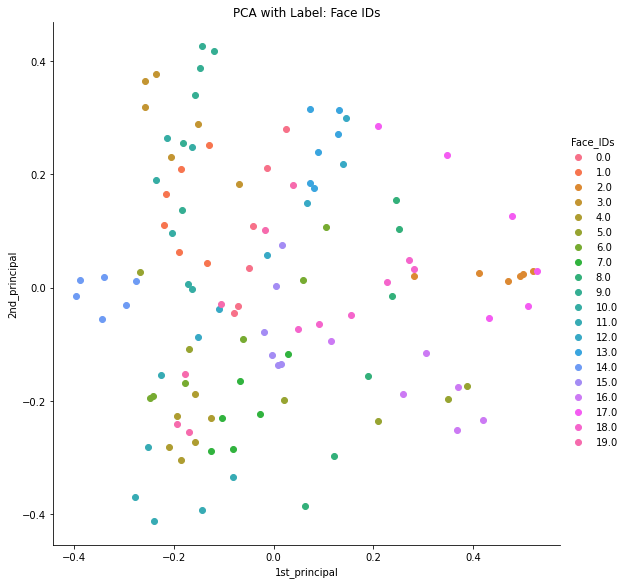

In [15]:
pca_data = pca.fit_transform(face_feature_vectors)
pca_data = np.vstack((pca_data.T, labels_face_id)).T
# creating a new data fram which help us in ploting the result data
pca_df = pd.DataFrame(data=pca_data, columns=("1st_principal", "2nd_principal", "Face_IDs"))
sn.FacetGrid(pca_df, hue="Face_IDs", height=8).map(plt.scatter, '1st_principal', '2nd_principal').add_legend()
plt.title('PCA with Label: Face IDs')
plt.show()

## Label: Morph Levels

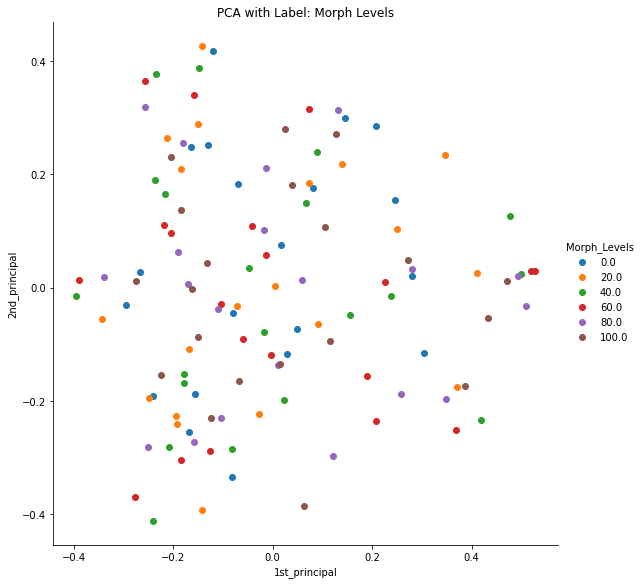

In [16]:
pca_data = pca.fit_transform(face_feature_vectors)
pca_data = np.vstack((pca_data.T, labels_morph_level)).T
# creating a new data fram which help us in ploting the result data
pca_df = pd.DataFrame(data=pca_data, columns=("1st_principal", "2nd_principal", "Morph_Levels"))
sn.FacetGrid(pca_df, hue="Morph_Levels", height=8).map(plt.scatter, '1st_principal', '2nd_principal').add_legend()
plt.title('PCA with Label: Morph Levels')
plt.show()

# t-SNE 2D

In [35]:
tsne = TSNE(n_components=2, random_state=0, perplexity=15)
# configuring the parameteres
# the number of components = 2
# default perplexity = 30
# default learning rate = 200
# default Maximum number of iterations for the optimization = 1000

## Label: Face IDs

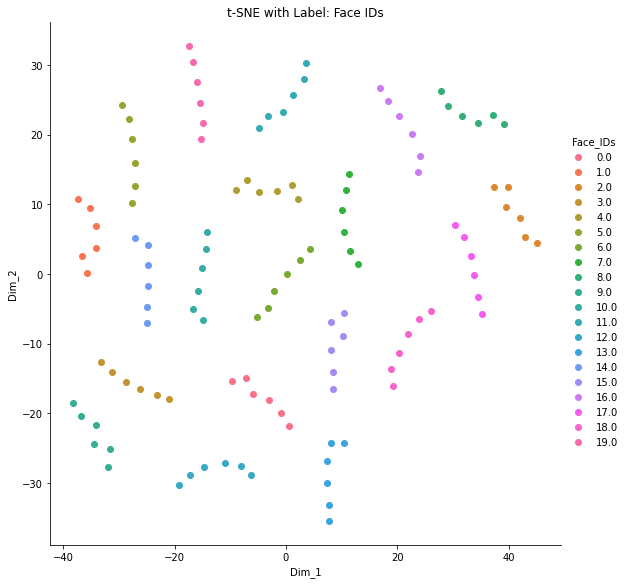

In [36]:
tsne_data = tsne.fit_transform(face_feature_vectors)
# creating a new data frame which help us in ploting the result data
tsne_data = np.vstack((tsne_data.T, labels_face_id)).T
tsne_df = pd.DataFrame(data=tsne_data, columns=("Dim_1", "Dim_2", "Face_IDs"))

# Ploting the result of tsne
sn.FacetGrid(tsne_df, hue="Face_IDs", height=8).map(plt.scatter, 'Dim_1', 'Dim_2').add_legend()
plt.title('t-SNE with Label: Face IDs')
plt.show()

## Label: Morph Levels

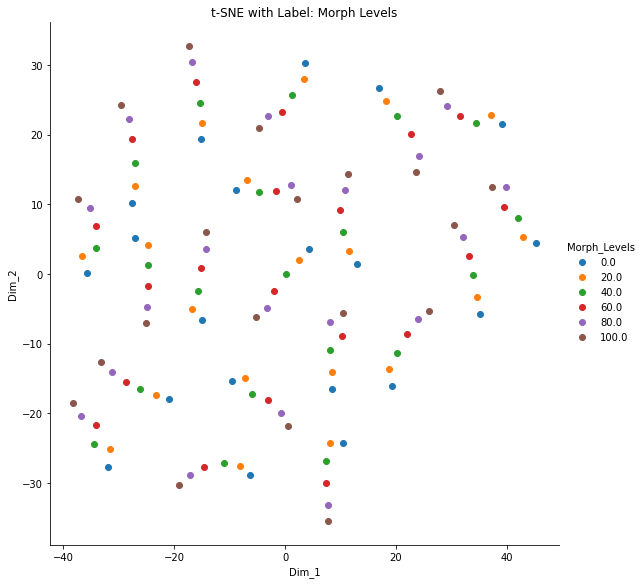

In [37]:
tsne_data = tsne.fit_transform(face_feature_vectors)
# creating a new data frame which help us in ploting the result data
tsne_data = np.vstack((tsne_data.T, labels_morph_level)).T
tsne_df = pd.DataFrame(data=tsne_data, columns=("Dim_1", "Dim_2", "Morph_Levels"))

# Ploting the result of tsne
sn.FacetGrid(tsne_df, hue="Morph_Levels", height=8).map(plt.scatter, 'Dim_1', 'Dim_2').add_legend()
plt.title('t-SNE with Label: Morph Levels')
plt.show()

## Perplexity: 5

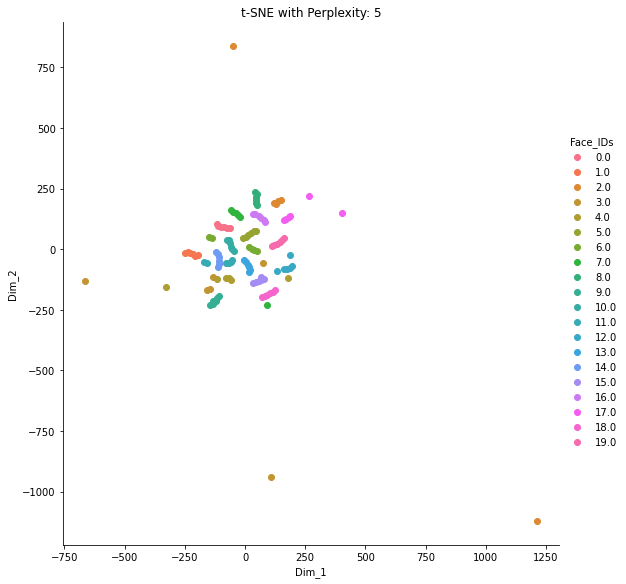

In [38]:
tsne = TSNE(n_components=2, random_state=0, perplexity=5)
tsne_data = tsne.fit_transform(face_feature_vectors)
# creating a new data frame which help us in ploting the result data
tsne_data = np.vstack((tsne_data.T, labels_face_id)).T
tsne_df = pd.DataFrame(data=tsne_data, columns=("Dim_1", "Dim_2", "Face_IDs"))

# Ploting the result of tsne
sn.FacetGrid(tsne_df, hue="Face_IDs", height=8).map(plt.scatter, 'Dim_1', 'Dim_2').add_legend()
plt.title('t-SNE with Perplexity: 5')
plt.show()

## Perplexity: 12

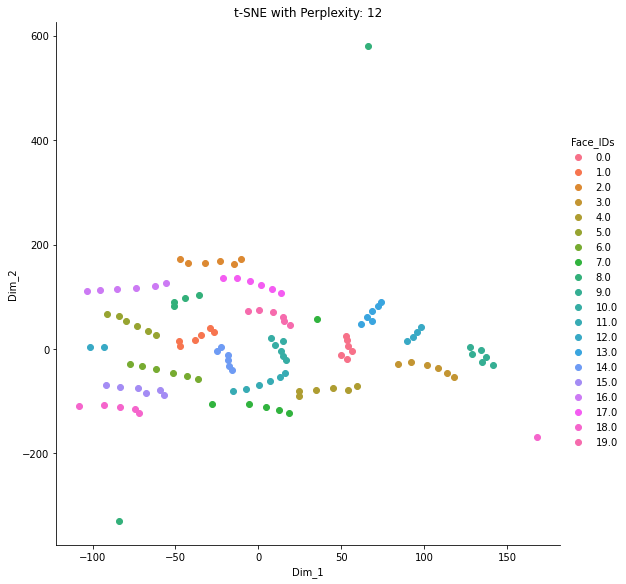

In [39]:
tsne = TSNE(n_components=2, random_state=0, perplexity=12)
tsne_data = tsne.fit_transform(face_feature_vectors)
# creating a new data frame which help us in ploting the result data
tsne_data = np.vstack((tsne_data.T, labels_face_id)).T
tsne_df = pd.DataFrame(data=tsne_data, columns=("Dim_1", "Dim_2", "Face_IDs"))

# Ploting the result of tsne
sn.FacetGrid(tsne_df, hue="Face_IDs", height=8).map(plt.scatter, 'Dim_1', 'Dim_2').add_legend()
plt.title('t-SNE with Perplexity: 12')
plt.show()

## Perplexity: 15

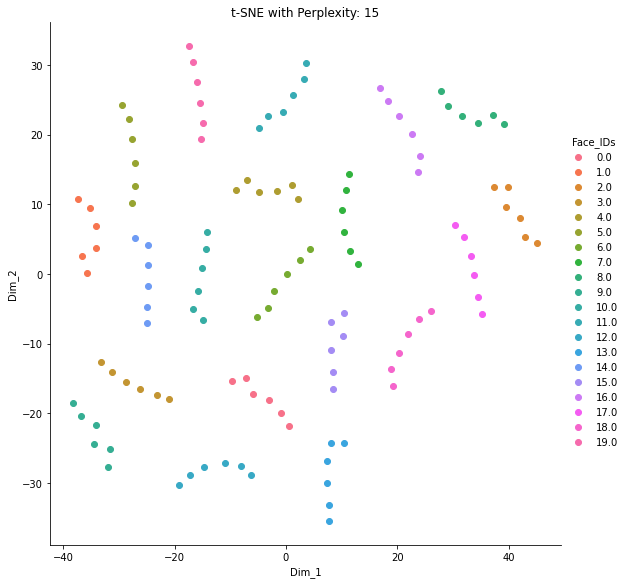

In [40]:
tsne = TSNE(n_components=2, random_state=0, perplexity=15)
tsne_data = tsne.fit_transform(face_feature_vectors)
# creating a new data frame which help us in ploting the result data
tsne_data = np.vstack((tsne_data.T, labels_face_id)).T
tsne_df = pd.DataFrame(data=tsne_data, columns=("Dim_1", "Dim_2", "Face_IDs"))

# Ploting the result of tsne
sn.FacetGrid(tsne_df, hue="Face_IDs", height=8).map(plt.scatter, 'Dim_1', 'Dim_2').add_legend()
plt.title('t-SNE with Perplexity: 15')
plt.show()

## Perplexity: 25

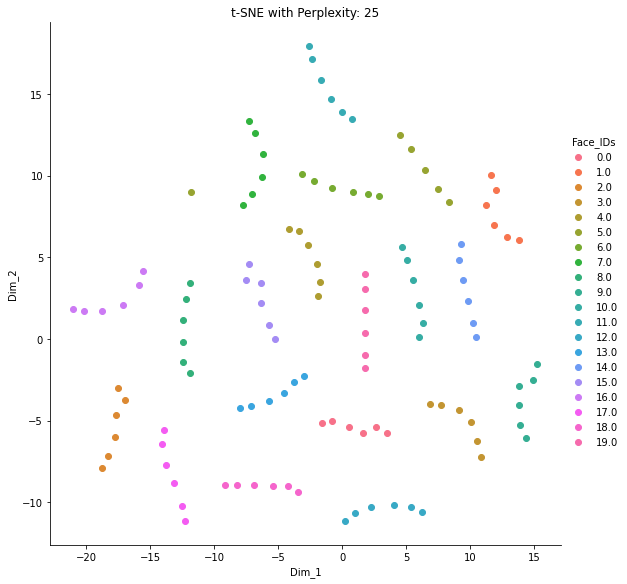

In [41]:
tsne = TSNE(n_components=2, random_state=0, perplexity=25)
tsne_data = tsne.fit_transform(face_feature_vectors)
# creating a new data frame which help us in ploting the result data
tsne_data = np.vstack((tsne_data.T, labels_face_id)).T
tsne_df = pd.DataFrame(data=tsne_data, columns=("Dim_1", "Dim_2", "Face_IDs"))

# Ploting the result of tsne
sn.FacetGrid(tsne_df, hue="Face_IDs", height=8).map(plt.scatter, 'Dim_1', 'Dim_2').add_legend()
plt.title('t-SNE with Perplexity: 25')
plt.show()

## Perplexity: 60

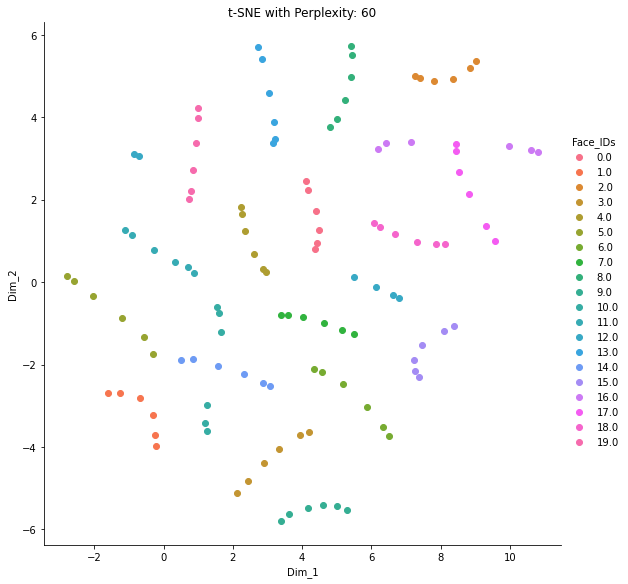

In [42]:
tsne = TSNE(n_components=2, random_state=0, perplexity=60)
tsne_data = tsne.fit_transform(face_feature_vectors)
# creating a new data frame which help us in ploting the result data
tsne_data = np.vstack((tsne_data.T, labels_face_id)).T
tsne_df = pd.DataFrame(data=tsne_data, columns=("Dim_1", "Dim_2", "Face_IDs"))

# Ploting the result of tsne
sn.FacetGrid(tsne_df, hue="Face_IDs", height=8).map(plt.scatter, 'Dim_1', 'Dim_2').add_legend()
plt.title('t-SNE with Perplexity: 60')
plt.show()

## Perplexity: 120

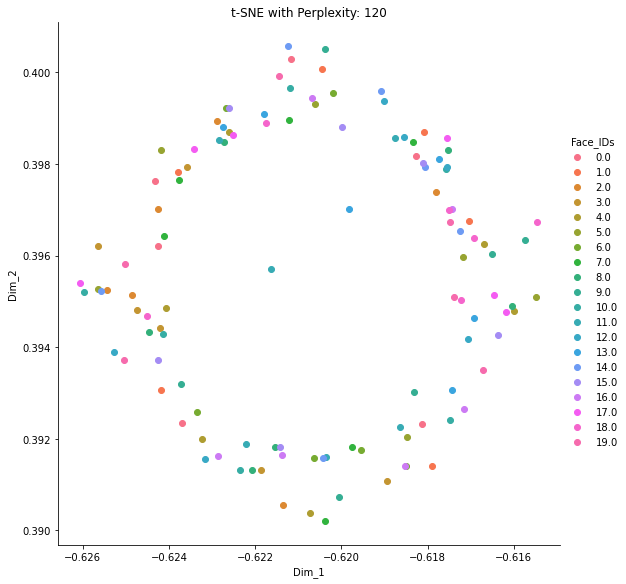

In [45]:
tsne = TSNE(n_components=2, random_state=0, perplexity=120)
tsne_data = tsne.fit_transform(face_feature_vectors)
# creating a new data frame which help us in ploting the result data
tsne_data = np.vstack((tsne_data.T, labels_face_id)).T
tsne_df = pd.DataFrame(data=tsne_data, columns=("Dim_1", "Dim_2", "Face_IDs"))

# Ploting the result of tsne
sn.FacetGrid(tsne_df, hue="Face_IDs", height=8).map(plt.scatter, 'Dim_1', 'Dim_2').add_legend()
plt.title('t-SNE with Perplexity: 120')
plt.show()